In [1]:
import scipy.stats
import scipy.special
from scipy.stats import norm 

import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern,ConstantKernel,WhiteKernel

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#Objective function
def f(x):
    return -1*2*np.sin(x+1)*x

In [3]:
def suggest(gpr,y_sample,bound,acq='EI'):
    def acquisition(x):
        x=np.array(x).reshape(1,-1)
        mu,std = gpr.predict(x,return_std=True)
        best_y=y_sample.min()
        if acq=='EI': #Expected Improvement
            gamma=(best_y-mu)/std
            return -((best_y-mu)*norm.cdf(gamma)+norm.pdf(gamma))
        elif acq=='PI': #Probability Improvement
            return -norm.cdf(best_y,loc=mu,scale=std)
        elif acq=='LCB': #confidence bound (Lower for minimization)
            return mu -1.8*std
    x_est=np.linspace(bound[0][0],bound[0][1],100).reshape(100,)
    y_acq=[]
    for i in range(100):
        y_acq.append(-1*acquisition(x_est[i]))
    Y_acq=np.array(y_acq)
    x_next=x_est[np.argmax(Y_acq)]
    plt.plot(x_est,Y_acq,color='k')
    plt.plot(x_next*np.ones((10,1)),
    np.linspace(Y_acq.min(),Y_acq.max(),10),label='Maximum')
    plt.title(f'Acquisition Function-{acq}')
    plt.xlabel('$x$')
    plt.legend(loc='upper right')
    plt.show()
    #rand_point=np.random.rand(1)*20-10
    #opt=minimize(acquisition,x0=rand_point,bounds=bound,method='BFGS' )
    #print(x_sample.mean())
    #x_next=np.array(opt.x)
    
    return x_next

In [4]:
def plot_gaussian(x_sample,y_sample,x_new,mu,std,title):
    fig,ax=plt.subplots()
    plt.plot(x_new,mu,'-',color='b',label='mean')
    plt.plot(x_new,mu+2*std,'-',color='b',linewidth=0.5,label='confidence')
    plt.plot(x_new,mu-2*std,'-',color='b',linewidth=0.5)
    ax.fill_between(x,mu+2*std,mu-2*std,color='grey')
    plt.scatter(x_sample,y_sample,s=50,c='k',marker='*',label='sample')
    plt.title(title)
    plt.legend(loc='upper left')

In [9]:
x=np.linspace(-10,10,100) #search range
#new point for further prediction
x_new=np.linspace(-10,10,100).reshape(100,1)
#sample (I include edge points in samples)
x_=20*np.random.rand(4,1)-10
x_=np.vstack((np.array(-10),np.array(10),x_))
y_=f(x_)

In [5]:
theta0=ConstantKernel(np.random.rand(1)*5) #covariance function amplitude
theta=np.random.rand(1)*10
nu=np.random.randint(-10,10)*1e-4
#define kerne
Sqrexp=theta0**2*RBF(length_scale=theta,length_scale_bounds=(1e-9, 1e1))
+nu*WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1)) #Squared Exponential(RBF)
Matern52=theta0**2*Matern(length_scale=theta,length_scale_bounds=(1e-9, 1e1),nu=2.5)
+nu*WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1)) #Matern52
#fit gaussian process with sample data
gpr_SQE_EI=GaussianProcessRegressor(kernel=Sqrexp)
gpr_SQE_PI=GaussianProcessRegressor(kernel=Sqrexp)
gpr_SQE_LCB=GaussianProcessRegressor(kernel=Sqrexp)
gpr_Mat_EI=GaussianProcessRegressor(kernel=Matern52)
gpr_Mat_PI=GaussianProcessRegressor(kernel=Matern52)
gpr_Mat_LCB=GaussianProcessRegressor(kernel=Matern52)

In [6]:
def iteration(gpr,x_sample,y_sample,bound,function,title,acq='EI',max_iter=10):
    fmin=np.zeros((max_iter,1))
    for i in range(max_iter):
        gpr.fit(x_sample,y_sample)
        mu,std=gpr.predict(x_new,return_std=True)
        new_point=suggest(gpr,y_,bound,acq=acq)
        print('Next point to evaluate: ',new_point)
        x_sample=np.vstack((x_sample,new_point))
        y_sample=function(x_sample)
        fmin[i]=y_sample.min()
        plot_gaussian(x_sample,y_sample,x_new,mu,std,title)
        plt.plot(x,function(x),'--',color='k')
        plt.scatter(new_point,function(new_point),s=20,c='r',label='next point')
        plt.legend(loc='upper right')
        plt.show()
    return fmin
                

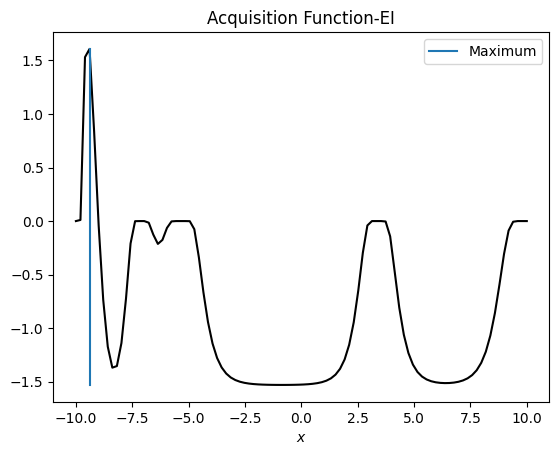

Next point to evaluate:  -9.393939393939394


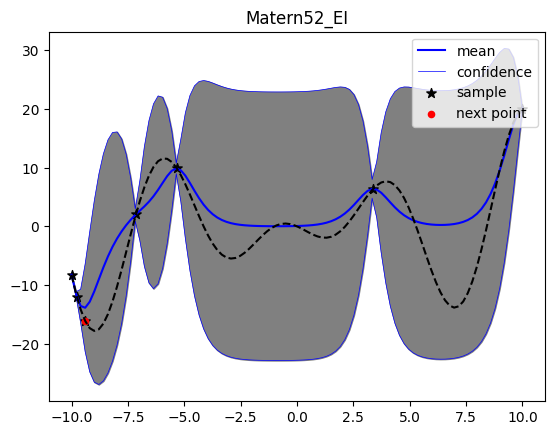

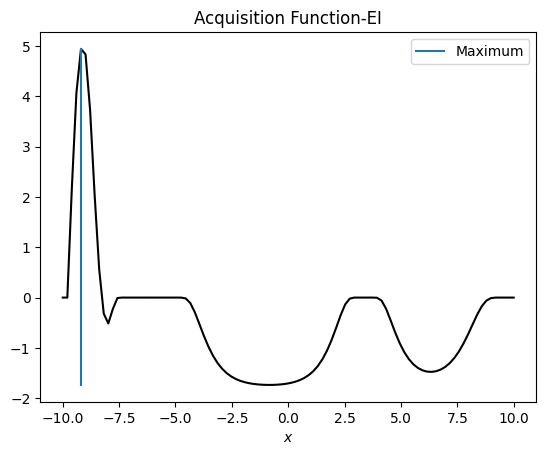

Next point to evaluate:  -9.191919191919192


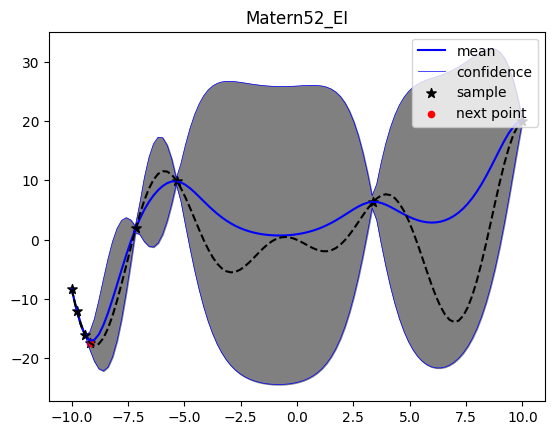

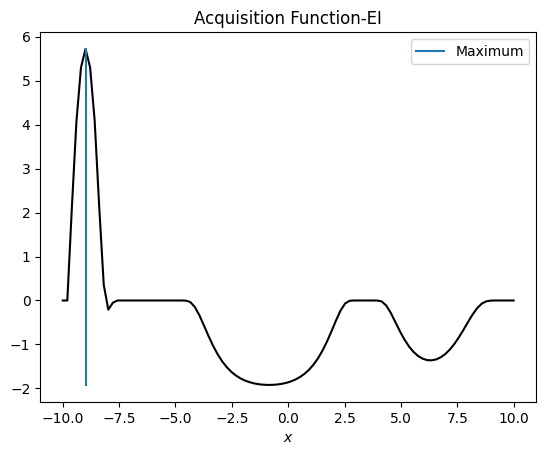

Next point to evaluate:  -8.98989898989899


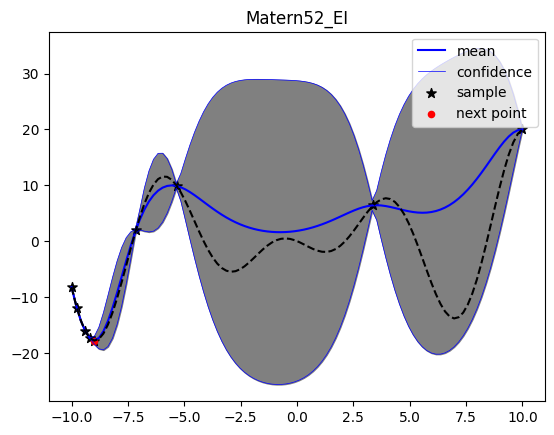

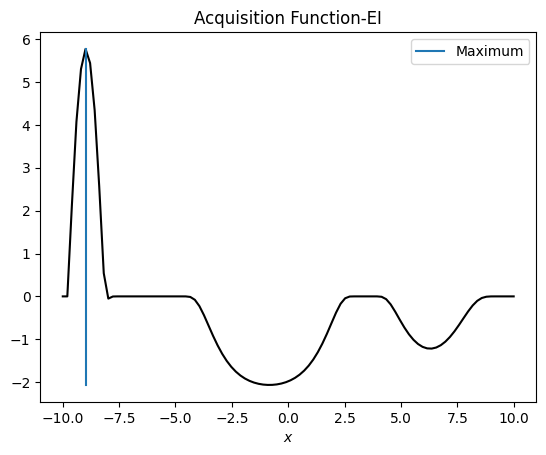

Next point to evaluate:  -8.98989898989899


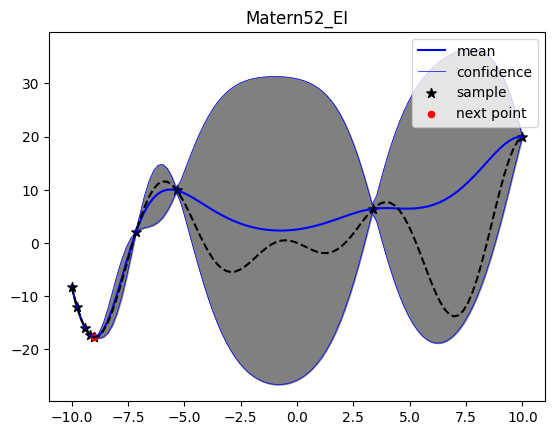

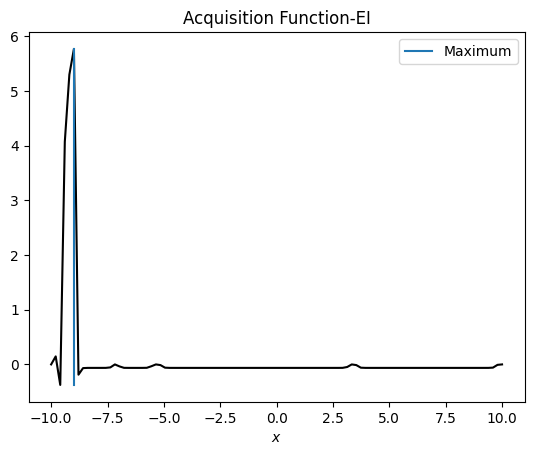

Next point to evaluate:  -8.98989898989899


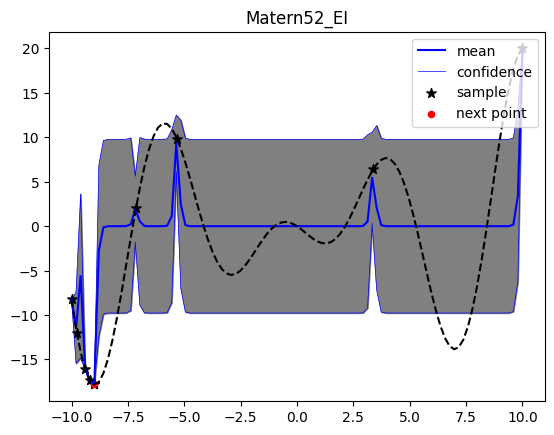

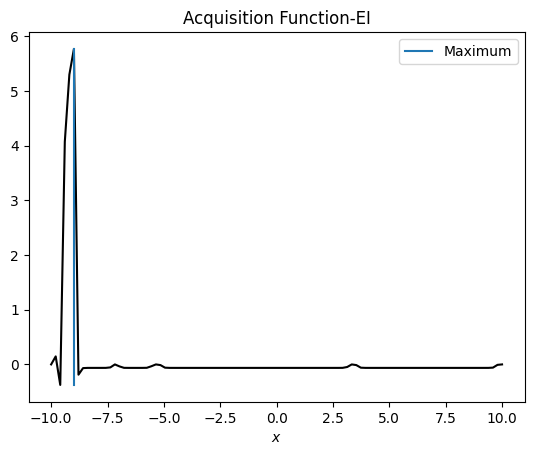

Next point to evaluate:  -8.98989898989899


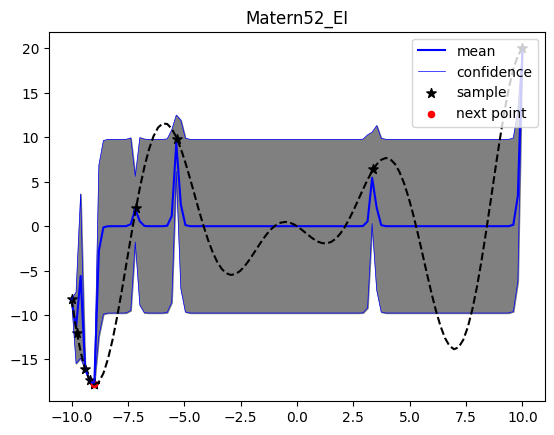

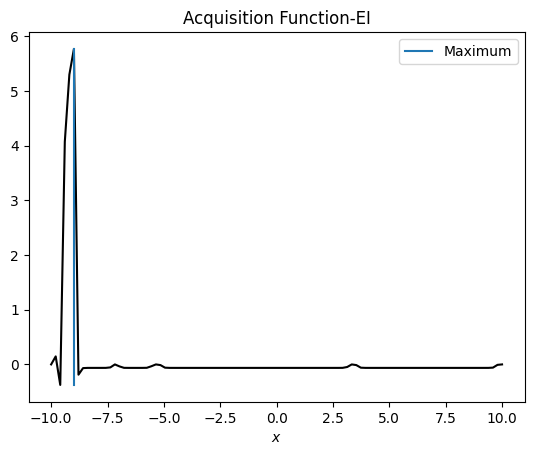

Next point to evaluate:  -8.98989898989899


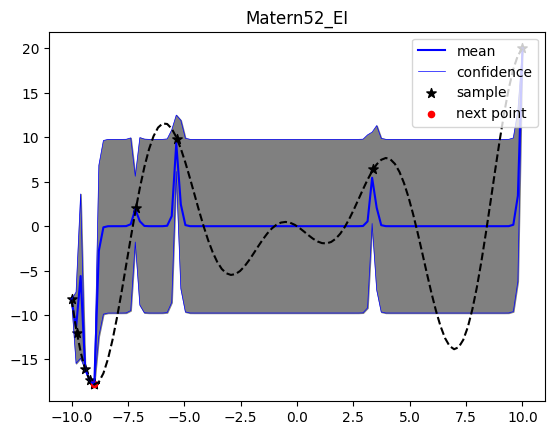

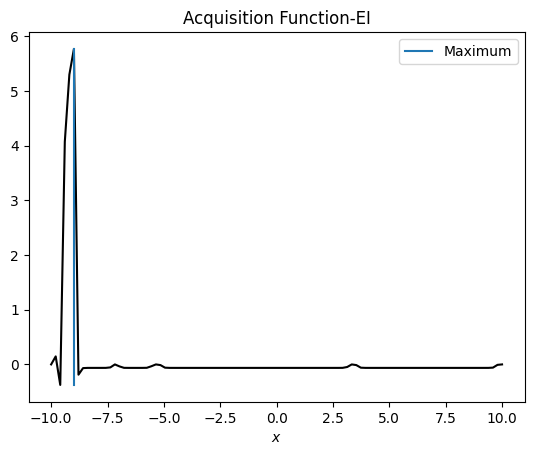

Next point to evaluate:  -8.98989898989899


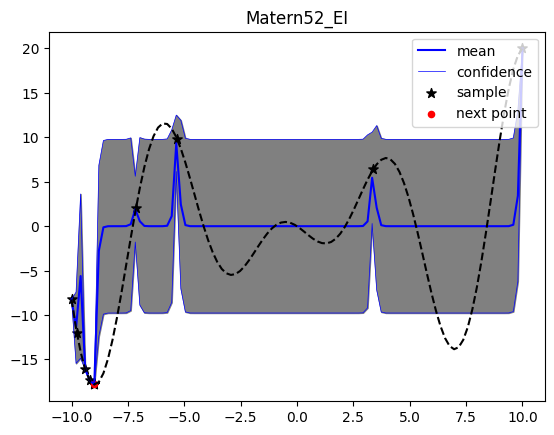

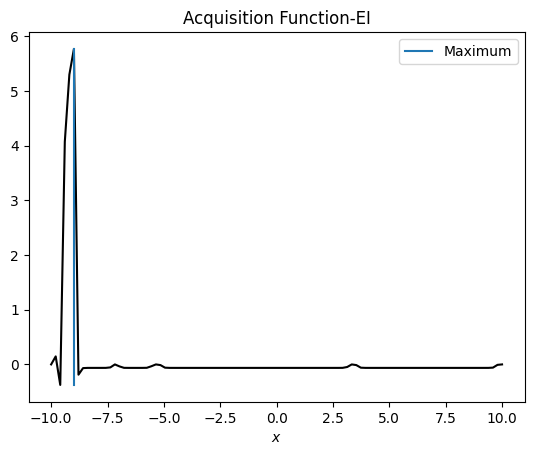

Next point to evaluate:  -8.98989898989899


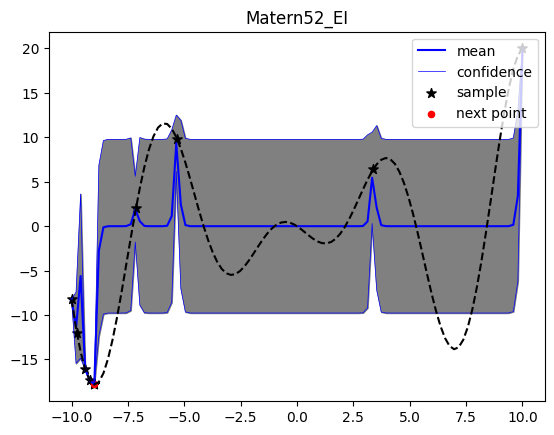

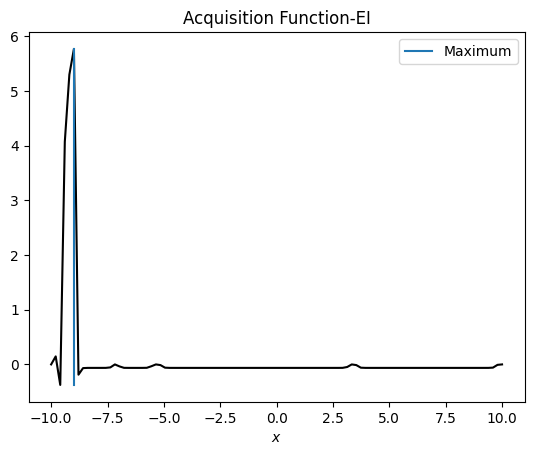

Next point to evaluate:  -8.98989898989899


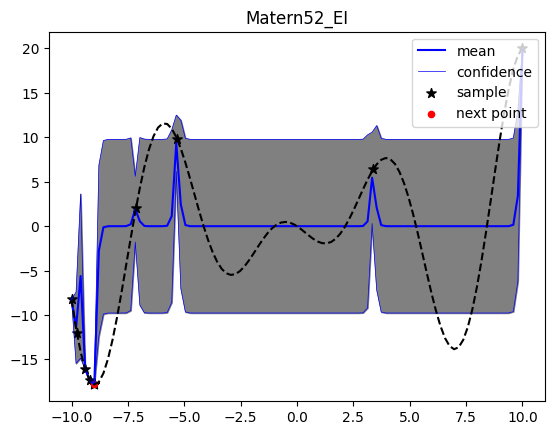

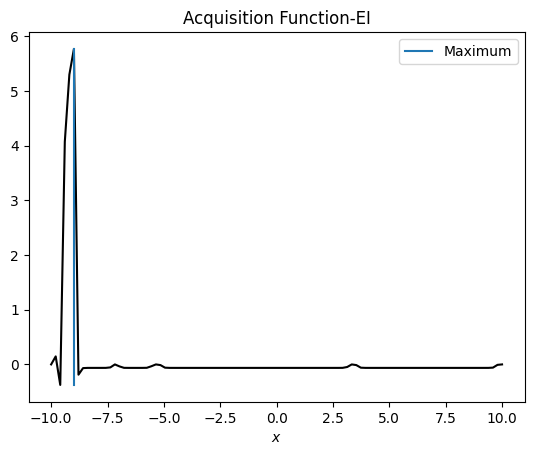

Next point to evaluate:  -8.98989898989899


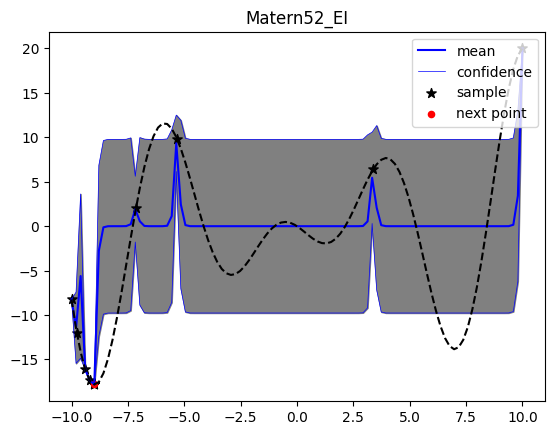

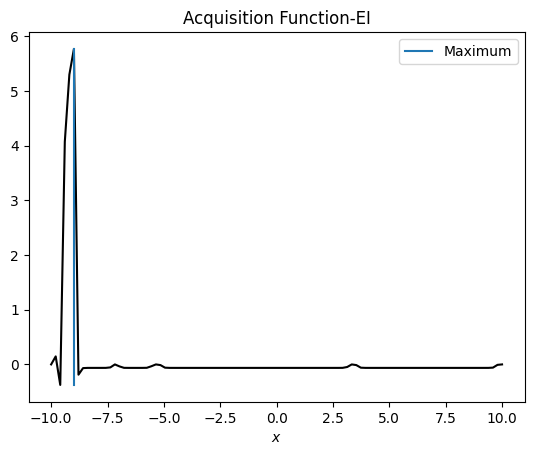

Next point to evaluate:  -8.98989898989899


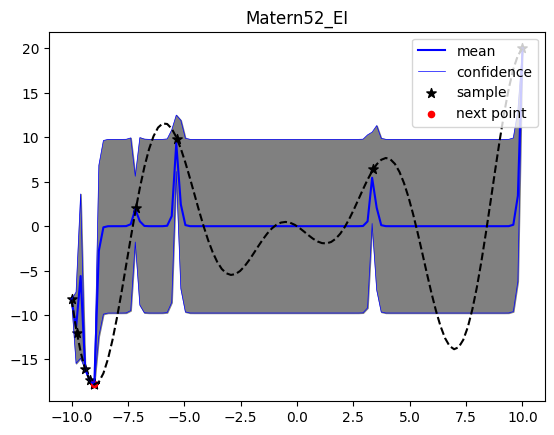

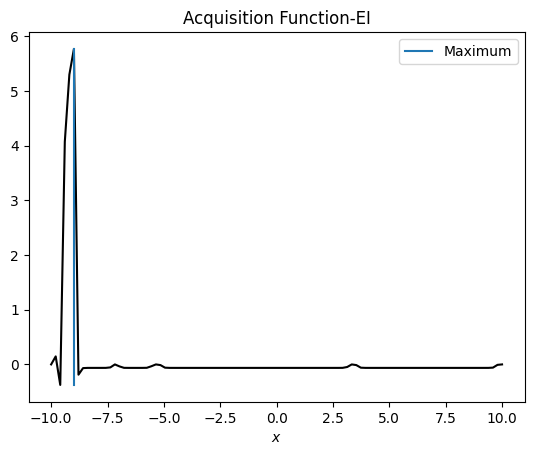

Next point to evaluate:  -8.98989898989899


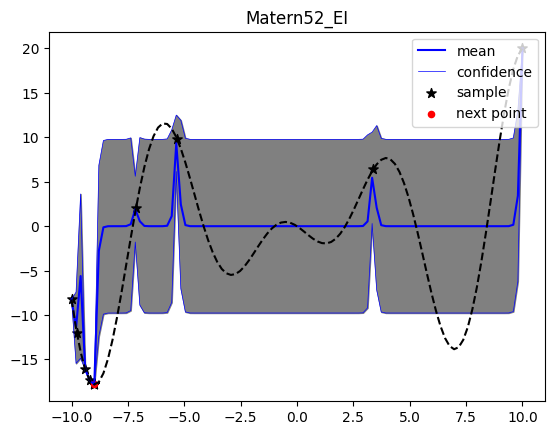

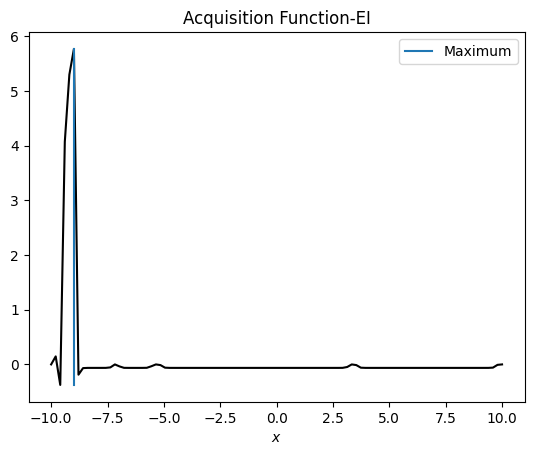

Next point to evaluate:  -8.98989898989899


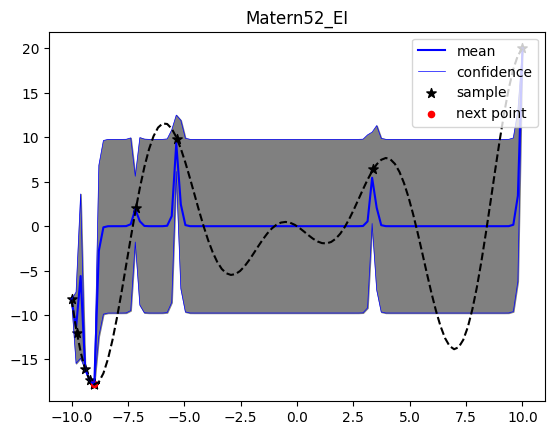

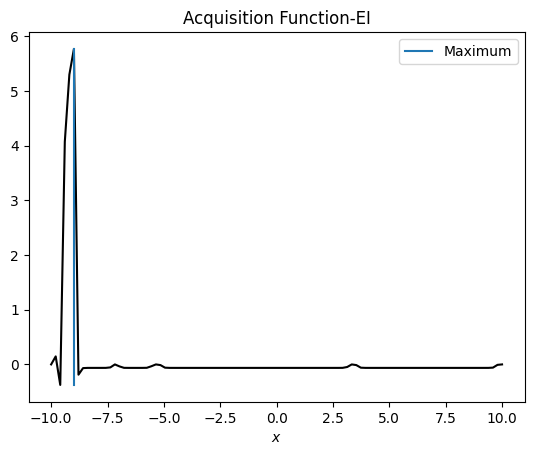

Next point to evaluate:  -8.98989898989899


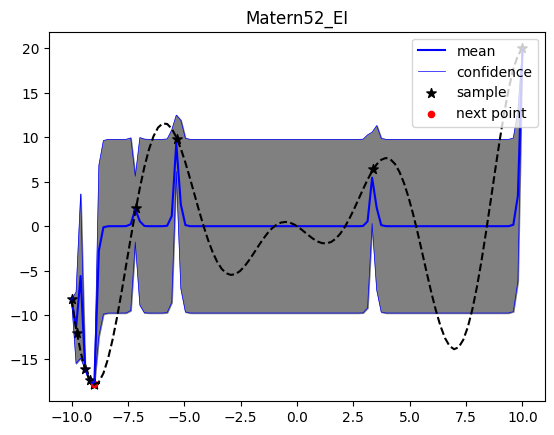

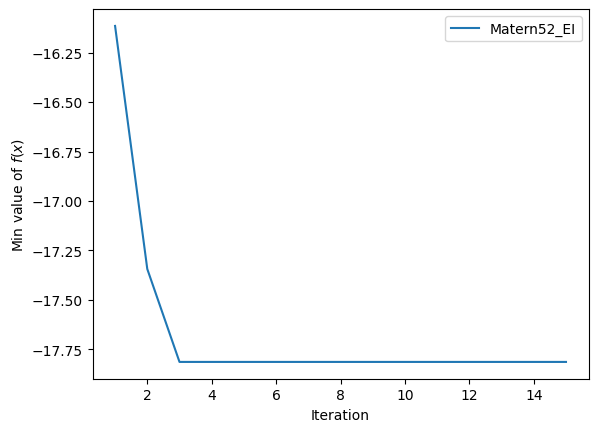

In [10]:
max_iter=15
bound=[(-10,10)]
#fminSQE_EI=iteration(gpr_SQE_EI,x_,y_,bound,f,title='RBF_EI',acq='EI',max_iter=max_iter)
#fminSQE_PI=iteration(gpr_SQE_PI,x_,y_,bound,f,title='RBF_PI',acq='PI',max_iter=max_iter)
#fminSQE_LCB=iteration(gpr_SQE_LCB,x_,y_,bound,f,title='RBF_LCB',acq='LCB',max_iter=max_iter)  
fminMAT_EI=iteration(gpr_Mat_EI,x_,y_,bound,f,title='Matern52_EI',acq='EI',max_iter=max_iter)
#fminMAT_PI=iteration(gpr_Mat_PI,x_,y_,bound,f,title='Matern52_PI',acq='PI',max_iter=max_iter)
#fminMAT_LCB=iteration(gpr_Mat_LCB,x_,y_,bound,f,title='Matern52_LCB',acq='LCB',max_iter=max_iter)

#plt.plot(np.arange(1,max_iter+1),fminSQE_EI,label='RBF_EI')
#plt.plot(np.arange(1,max_iter+1),fminSQE_PI,label='RBF_PI')
#plt.plot(np.arange(1,max_iter+1),fminSQE_LCB,label='RBF_LCB')
plt.plot(np.arange(1,max_iter+1),fminMAT_EI,label='Matern52_EI')
#plt.plot(np.arange(1,max_iter+1),fminMAT_PI,label='Matern52_PI')
#plt.plot(np.arange(1,max_iter+1),fminMAT_LCB,label='Matern52_LCB')
plt.xlabel('Iteration')
plt.ylabel('Min value of $f(x)$')
#plt.axis('equal')
plt.legend(loc='upper right')